In [16]:
import matplotlib.pyplot as plt
import emcee
import numpy as np
import batman
import scipy.stats as stats
import pickle
from multiprocessing import Pool
import pygtc
import corner
from MCMC_Class import MCMC

%matplotlib widget

In [17]:
#theta
#0: t0
#1: period
#2: planet radius
#3: a
#4: i
#5: u1
#6: u2
#7: jitter

In [18]:
theta_tess = np.empty(8)

theta_tess[0] = 2459685.398095
theta_tess[1] = 3.2130578
theta_tess[2] = 0.1406
theta_tess[3] = 11.77
theta_tess[4] = 89
theta_tess[5] = 0.5019
theta_tess[6] = 0.1364
theta_tess[7] = 0.0

In [19]:
tess_dictionary23 = pickle.load((open('../Results/TESS/sector23_flatten.p', 'rb')))
bjd_tess23 = tess_dictionary23['time']
flux_tess23 = tess_dictionary23['pdcsap_masked_hspline_flux']
flux_error_tess23 = tess_dictionary23['pdcsap_masked_hspline_flux_error']

###############################################################################################

tess_dictionary49 = pickle.load((open('../Results/TESS/sector49_flatten.p', 'rb')))
bjd_tess49 = tess_dictionary49['time']
flux_tess49 = tess_dictionary49['pdcsap_masked_bw_flux']
flux_error_tess49 = tess_dictionary49['pdcsap_masked_bw_flux_error']

###############################################################################################

tess_dictionary50 = pickle.load((open('../Results/TESS/sector50_flatten.p', 'rb')))
bjd_tess50 = tess_dictionary50['time']
flux_tess50 = tess_dictionary50['pdcsap_masked_hspline_flux']
flux_error_tess50 = tess_dictionary50['pdcsap_masked_hspline_flux_error']

###############################################################################################

tess_dictionary76 = pickle.load((open('../Results/TESS/sector76_flatten.p', 'rb')))
bjd_tess76 = tess_dictionary76['time']
flux_tess76 = tess_dictionary76['pdcsap_masked_bw_flux']
flux_error_tess76 = tess_dictionary76['pdcsap_masked_bw_flux_error']

bjd_tess = [bjd_tess23, bjd_tess49, bjd_tess50, bjd_tess76]
flux_tess = [flux_tess23, flux_tess49, flux_tess50, flux_tess76]
flux_error_tess = [flux_error_tess23, flux_error_tess49, flux_error_tess50, flux_error_tess76]

In [20]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    chi2_tess = []
    sum_ln_sigma_tess = []

    for i in range(0, 4):
        m_tess = batman.TransitModel(params, bjd_tess[i])
        tess_model = m_tess.light_curve(params)
        tess_errors_with_jitter = flux_error_tess[i]**2 + theta[7]**2
        chi2_tess = np.append(np.sum((flux_tess[i]-tess_model)**2 / tess_errors_with_jitter), chi2_tess)
        sum_ln_sigma_tess = np.append(np.sum(np.log(tess_errors_with_jitter)), sum_ln_sigma_tess)

    N = len(tess_errors_with_jitter)

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess[0] + chi2_tess[1] + chi2_tess[2] + chi2_tess[3] + 
                             sum_ln_sigma_tess[0] + sum_ln_sigma_tess[1] + sum_ln_sigma_tess[2] + sum_ln_sigma_tess[3])

    return log_likelihood

In [21]:
def log_prior(theta):
    prior = 0.00
    prior+= np.log(stats.norm.pdf(theta[5], loc=0.5019, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[6], loc=0.1364, scale=0.10))
    return prior

boundaries = np.empty([2, len(theta_tess)])

boundaries[:,0] = [theta_tess[0]-0.5, theta_tess[0]+0.5]
boundaries[:,1] = [theta_tess[1]-0.5, theta_tess[1]+0.5]
boundaries[:,2] = [0.0, 0.5]
boundaries[:,3] = [0.0, 20.]
boundaries[:,4] = [80.0, 90.0]
boundaries[:,5] = [0.00, 1.0]
boundaries[:,6] = [0.00, 1.0]
boundaries[:,7] = [0.0, 0.05]

def log_posterior(theta):
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_prob = log_prior(theta)

    log_prob += log_likelihood(theta)
    return log_prob

In [22]:
#Run the MCMC

nwalkers = 50
nsteps = 20000
ndim = len(theta_tess)
starting_point = theta_tess + np.abs(1e-5 * np.random.randn(nwalkers, ndim))

In [23]:
with Pool() as pool:
    tess_mcmc = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)
    tess_mcmc.run_mcmc(starting_point, nsteps, progress=True)

  0%|          | 76/20000 [00:01<08:39, 38.39it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'step number')

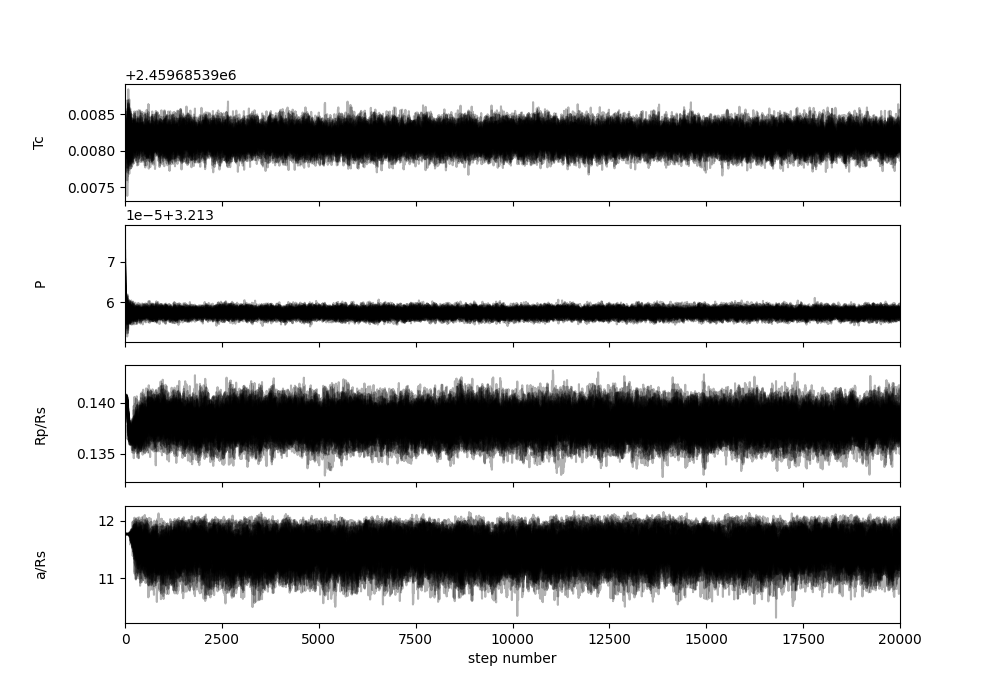

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = tess_mcmc.get_chain()
labels = ["Tc", "P", "Rp/Rs", "a/Rs"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

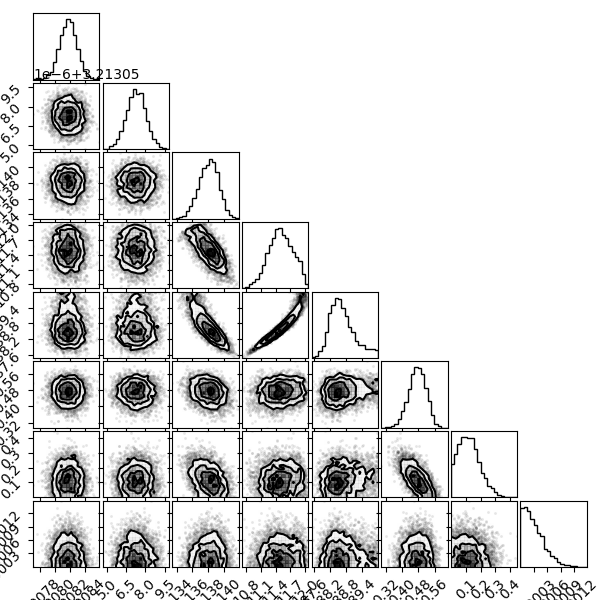

In [ ]:
flat_samples = tess_mcmc.get_chain(discard=5000, thin=150, flat=True)

fig = plt.figure(figsize=(6, 6))
corner.corner(flat_samples, fig=fig)
plt.show()

In [11]:
pickle.dump(tess_mcmc, open('../Results/MCMC/TESS/run_alltess_v3.p', 'wb'))

In [13]:
sector_list = ('23', '49', '50', '76')

for i in range(4):

    bjd = bjd_tess[i]
    flux = flux_tess[i]
    flux_error = flux_error_tess[i]

    def log_likelihood(theta):

        params = batman.TransitParams()
        params.t0 =  theta[0]                
        params.per = theta[1]                    
        params.rp =  theta[2]                 
        params.a =   theta[3]                   
        params.inc =  theta[4]    
        params.ecc = 0.
        params.w = 90. 
        params.u = [theta[5] , theta[6]]
        params.limb_dark = "quadratic"

        m_tess = batman.TransitModel(params, bjd)
        tess_model = m_tess.light_curve(params)
    
        tess_errors_with_jitter = flux_error**2 + theta[7]**2

        N = len(tess_errors_with_jitter)

        chi2_tess = np.sum( (flux - tess_model)**2 / tess_errors_with_jitter)
        sum_ln_sigma_tess = np.sum(np.log(tess_errors_with_jitter))

        log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess  + sum_ln_sigma_tess)

        return log_likelihood
    
    def log_prior(theta):
        prior = 0.00
        prior+= np.log(stats.norm.pdf(theta[5], loc=0.5019, scale=0.10))
        prior+= np.log(stats.norm.pdf(theta[6], loc=0.1364, scale=0.10))
        return prior

    boundaries = np.empty([2, len(theta_tess)])

    boundaries[:,0] = [theta_tess[0]-0.5, theta_tess[0]+0.5]
    boundaries[:,1] = [theta_tess[1]-0.5, theta_tess[1]+0.5]
    boundaries[:,2] = [0.0, 0.5]
    boundaries[:,3] = [0.0, 20.]
    boundaries[:,4] = [80.0, 90.0]
    boundaries[:,5] = [0.00, 1.0]
    boundaries[:,6] = [0.00, 1.0]
    boundaries[:,7] = [0.0, 0.05]

    def log_posterior(theta):
    
        sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
        if np.sum(sel) > 0:
            return -np.inf
    
        log_prob = log_prior(theta)

        log_prob += log_likelihood(theta)
        return log_prob
    
    nwalkers = 50
    nsteps = 20000
    ndim = len(theta_tess)
    starting_point = theta_tess + np.abs(1e-5 * np.random.randn(nwalkers, ndim))

    with Pool() as pool:
        tess_mcmc = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)
        tess_mcmc.run_mcmc(starting_point, nsteps, progress=True)

    pickle.dump(tess_mcmc, open('../Results/MCMC/TESS/run'+sector_list[i]+'_tess_v5.p', 'wb'))



100%|██████████| 20000/20000 [02:41<00:00, 123.80it/s]


In [14]:
#s50_mcmc = pickle.load(open('../Results/MCMC/TESS/run50_tess_v2.p', 'rb'))
#flat_samples = s50_mcmc.get_chain(discard=5000, thin=100, flat=True)

#fig = plt.figure(figsize=(6, 6))
#corner.corner(flat_samples, fig=fig)
#plt.show()

In [26]:
tess = pickle.load((open('../Results/MCMC/TESS/run_alltess_v3.p', 'rb')))

flat_samples = tess.get_chain(discard=5000, thin=100, flat=True)
print(flat_samples.shape)

ndim = len(theta_tess)

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))

(7500, 8)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>